# auto_arima

The R language has an `auto.arima` function, which can search for p, d, q automatically. There is a similar Python package [pmdarima](https://github.com/alkaline-ml/pmdarima), this notebook will use it to model Bitcoin prices.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from typing import List, Dict, Tuple

%matplotlib inline

In [2]:
import pmdarima as pm

print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.6.1


In [3]:
import warnings
#warnings.filterwarnings('ignore')

## 1. Data Exploration

In [4]:
from utils import read_bars as read_bars_tmp

# Read bars in May 2020
def read_bars(csv_file: str)->pd.DataFrame:
    # TIME_BEGIN = pd.to_datetime('2020-05-01T00:00:00.000Z').tz_localize(None)
    # TIME_END = pd.to_datetime('2020-06-01T00:00:00.000Z').tz_localize(None)
    TIME_BEGIN = pd.to_datetime('2020-05-12T00:00:00.000Z').tz_localize(None)
    TIME_END = pd.to_datetime('2020-05-14T00:00:00.000Z').tz_localize(None)
    bars_df = read_bars_tmp(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp_end'] < TIME_END)]
    return bars_df

In [5]:
time_bars = read_bars('/data/bars/TimeBar/60000/TimeBar.60000.Binance.Swap.BTC_USDT.csv')

In [6]:
time_bars

,exchange,market_type,pair,bar_type,bar_size,timestamp,timestamp_end,open,high,low,...,volume,volume_sell,volume_buy,volume_quote,volume_quote_sell,volume_quote_buy,count,count_sell,count_buy,vwap
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-12 00:00:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:00:00,2020-05-12 00:01:00,8560.730469,8561.879883,8540.769531,...,468.460,226.205,242.255,4005012.0,1933902.50,4004785.80,1060,506,554,8549.314776
2020-05-12 00:01:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:01:00,2020-05-12 00:02:00,8545.000000,8566.709961,8544.040039,...,321.819,223.273,98.546,2754213.0,1910834.60,2753989.80,904,610,294,8558.267225
2020-05-12 00:02:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:02:00,2020-05-12 00:03:00,8561.419922,8561.419922,8520.429688,...,519.416,187.146,332.270,4435116.0,1597941.40,4434929.00,1090,422,668,8538.658801
2020-05-12 00:03:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:03:00,2020-05-12 00:04:00,8534.389648,8548.549805,8534.059570,...,249.244,169.360,79.884,2129134.5,1446641.00,2128965.00,578,352,226,8542.370127
2020-05-12 00:04:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:04:00,2020-05-12 00:05:00,8543.940430,8570.969727,8542.769531,...,239.320,193.483,45.837,2048108.5,1655730.80,2047915.00,613,453,160,8558.033177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-13 23:54:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:54:00,2020-05-13 23:55:00,9298.000000,9302.209961,9297.490234,...,76.058,48.657,27.401,707271.4,452464.72,707222.75,209,128,81,9299.105945
2020-05-13 23:55:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:55:00,2020-05-13 23:56:00,9300.740234,9303.059570,9298.530273,...,74.680,23.799,50.881,694553.2,221346.73,694529.40,195,72,123,9300.391002
2020-05-13 23:56:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:56:00,2020-05-13 23:57:00,9299.509766,9299.799805,9286.160156,...,786.964,322.447,464.517,7312268.5,2996319.20,7311946.50,839,428,411,9291.744603


### 1.1 Plot price

In [7]:
prices = time_bars['vwap'].rename('price')

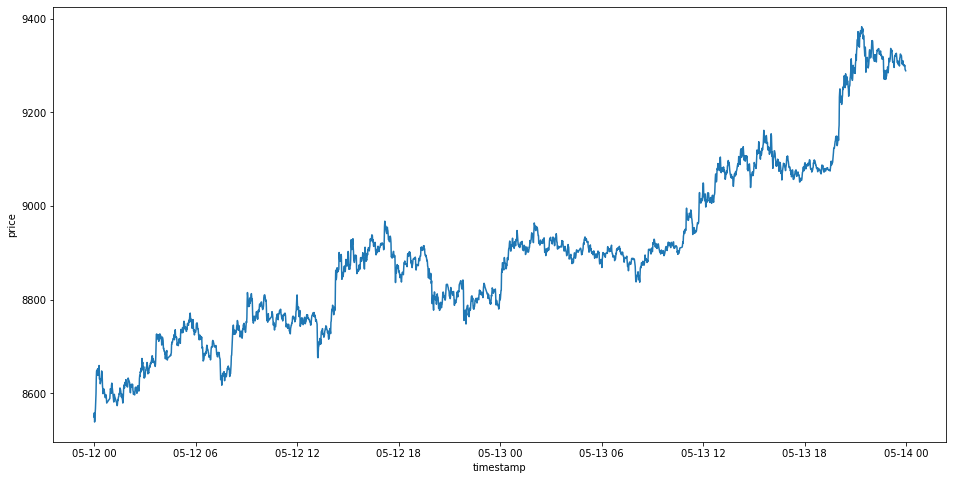

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=prices.index, y=prices, ax=ax)

There is a clear trend in the prices above, so the price time series is not stationary.

### 1.2 ADF test

In [9]:
adf_result = ADF(prices)

In [10]:
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Used lag: %f' % adf_result[2])
print('Number of observations: %f' % adf_result[3])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.850589
p-value: 0.803809
Used lag: 5.000000
Number of observations: 2798.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In the output above, we can see that ADF statistic value of `-0.850589` is greater than the value of `-3.433` at 1%. Besides, the p-value `0.803809` is greater than `0.05`. Both values support the null hypothesis, therefore price time series is not stationary.

### 1.3 Lag Plot

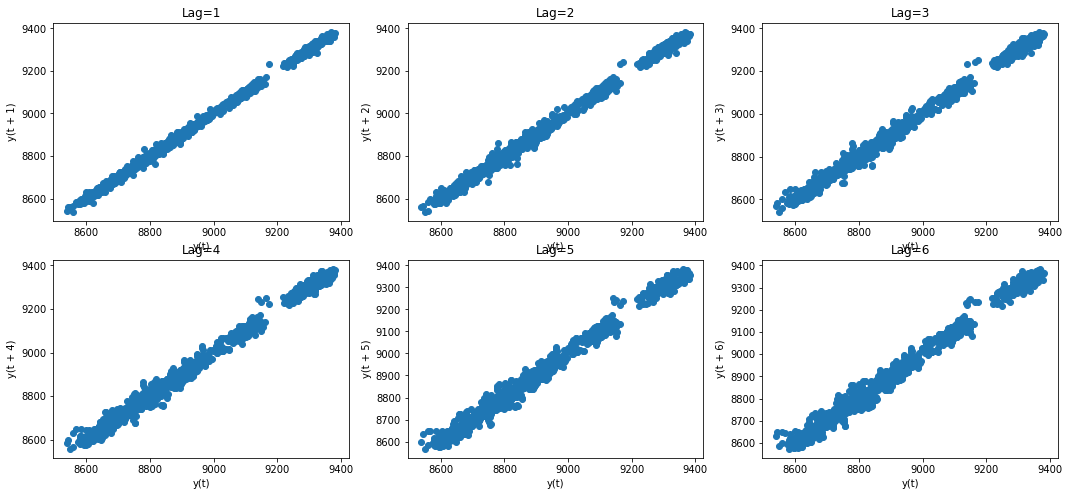

In [11]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
plt.title('Bitcoin Lag Plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (0, 2),
    (1, 0),
    (1, 1),
    (1, 2)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(prices, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

* A linear shape to the plot suggests that an autoregressive model is probably a better choice.
* An elliptical plot suggests that the data comes from a single-cycle sinusoidal model.

The 6 figures above are all linear shape, without cyclic ellipses. Thus it is appropriate to apply ARIMA method.

## 2. Estimating `p`, `q` and `d`

### 2.1 Estimating the differencing term `d`

In [12]:
from pmdarima.arima.utils import ndiffs

kpss_diffs = ndiffs(prices, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(prices, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


### 2.2 Estimating the orders of `p` and `q`

Usually we use partial autocorrelation to estimate the order `p` of `AR(p)` model and use autocorrelation to estimate the order `q` of `MA(q)` model, so let's first plot ACF and PACF.

Rules to identify the orders of AR or MA:

* The lag beyond which the PACF cuts off is the indicated order of AR.
* The lag beyond which the ACF cuts off is the indicated order of MA.

#### Plot ACF and PACF

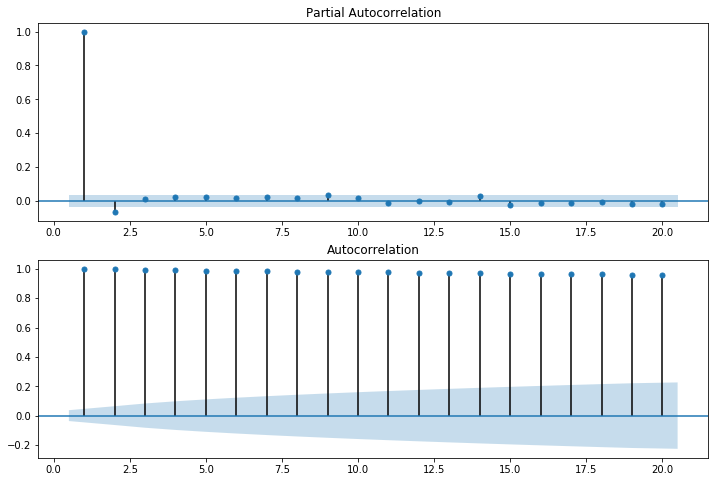

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(prices, lags=20, zero=False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(prices.values.squeeze(), lags=20, zero=False, ax=ax2)

* The PACF shuts off after lag 2.
* The ACF shows significant autocorrelations even after lag 20.

So we can tentatively set `max_p=4` and `max_q=10`.

## 3. Train the model

Split data into training dataset and test dataset:

In [14]:
train = prices[:int(prices.size * 0.8)]
test = prices[int(prices.size * 0.8):]

In [15]:
auto_arima_model = pm.auto_arima(
    train, d=1, seasonal=False, stepwise=True,
    suppress_warnings=True, error_action="ignore", max_p=4, max_q = 10,
    max_order=None, trace=True,
)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=15304.743, BIC=15339.033, Time=1.450 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15408.488, BIC=15419.919, Time=0.080 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=15336.329, BIC=15353.474, Time=0.322 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15319.581, BIC=15336.727, Time=0.503 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=15408.697, BIC=15414.412, Time=0.052 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=15302.902, BIC=15331.477, Time=1.131 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=15312.554, BIC=15335.415, Time=0.762 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15315.978, BIC=15338.838, Time=0.757 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=15304.696, BIC=15338.987, Time=1.595 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=15305.728, BIC=15334.304, Time=1.005 seconds
Fit ARIMA(2,1,1)

In [16]:
# auto_arima_model.summary()

In [17]:
print(auto_arima_model.order)

(1, 1, 2)


In [18]:
print(auto_arima_model.params())

[ 0.07358546  0.68791089 -0.49217094 -0.21478829 53.68801728]


In [19]:
print(auto_arima_model.aic(), auto_arima_model.bic(), auto_arima_model.hqic())

15302.901653268853 15331.477271287013 15313.333478337816


In [20]:
sm.stats.acorr_ljungbox(auto_arima_model.resid(), lags=1, return_df=True)

,lb_stat,lb_pvalue
1,0.002284,0.961881


The p-value of Ljung-Box test is much greater than 0.05, which indicates that residuals are white noise.

## 4. Update the model

Usually time series data have new data coming in endlessly, our model should be able to train online.

In [21]:
def forecast_one_step(model)->Tuple:
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0],
    )

Pretend `test` are new data.

In [22]:
forecasts = []
confidence_intervals = []

for new_ob in test:
    fc, conf = forecast_one_step(auto_arima_model)
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    auto_arima_model.update(new_ob)

## 5. Evaluate the model

### 5.1 Show some metrics

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mape(y_true: np.ndarray, y_pred: np.ndarray)->float:
    return np.mean(np.abs((y_pred - y_true) / y_true))

def smape(y_true: np.ndarray, y_pred: np.ndarray)->float:
    return 200.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def model_evaluate(y_true: np.ndarray, y_pred: np.ndarray)->Dict:
    MAE = mean_absolute_error(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    MAPE = mape(y_true, y_pred)
    sMAPE = smape(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    return {
        'MAE': MAE,
        'RMSE': RMSE,
        'MAPE': MAPE,
        'sMAPE': sMAPE,
        'R2': R2,
    }

In [24]:
model_evaluate(test, forecasts)

{'MAE': 5.863434446582907,
 'RMSE': 8.43330341453032,
 'MAPE': 0.0006368071514717614,
 'sMAPE': 0.06368333022387945,
 'R2': 0.9941023772375663}

### 5.2 Plot predicted prices

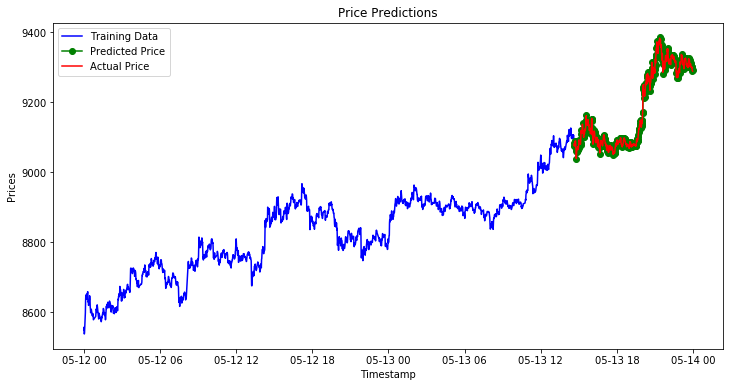

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

# --------------------- Actual vs. Predicted --------------------------
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o', label='Predicted Price')
ax.plot(test.index, test, color='red', label='Actual Price')
ax.set_title('Price Predictions')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Prices')

ax.legend()

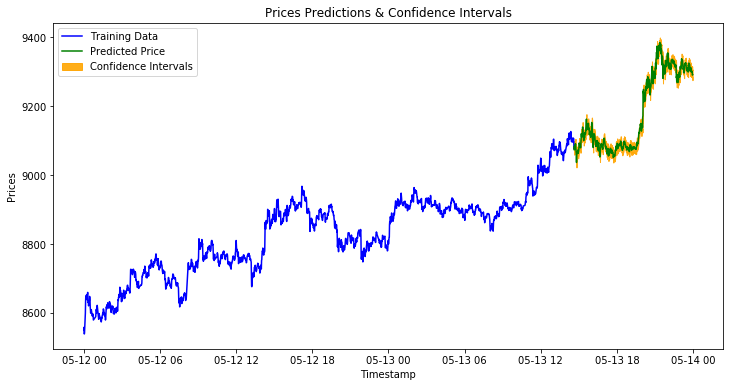

In [26]:
# ------------------ Predicted with confidence intervals ----------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', label='Predicted Price')

ax.set_title('Prices Predictions & Confidence Intervals')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
ax.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], alpha=0.9, color='orange', label="Confidence Intervals")

ax.legend()

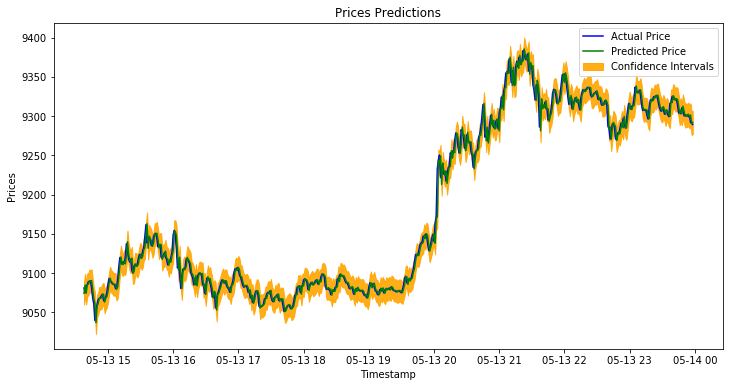

In [27]:
# ------------------ Zoom in on test data ----------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test.index, test, color='blue', label='Actual Price')
ax.plot(test.index, forecasts, color='green', label='Predicted Price')

ax.set_title('Prices Predictions & Confidence Intervals')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
ax.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], alpha=0.9, color='orange', label="Confidence Intervals")

ax.legend()

## References

* [github.com/alkaline-ml/pmdarima](https://github.com/alkaline-ml/pmdarima)
* [Stock Market Analysis Using ARIMA - Towards Data Science](https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a)
* [Stock market prediction - pmdarima documentation](https://alkaline-ml.com/pmdarima/usecases/stocks.html)
* [Tips to using auto_arima - pmdarima documentation](https://alkaline-ml.com/pmdarima/tips_and_tricks.html)
* [auto.arima function | R Documentation](https://www.rdocumentation.org/packages/forecast/versions/8.12/topics/auto.arima)